In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats



In [3]:
# Load the dataset
df = pd.read_csv(r"C:\Users\manik\Desktop\Github\Supply Chain Inventory Optimization\data\supply_chain_data.csv")


In [4]:
# Check for missing values
print(df.isnull().sum())

# Fill missing values (if any)
df.fillna(method='ffill', inplace=True)

# Check data types
print(df.dtypes)

# Convert price and cost-related columns to float (if needed)
df['Price'] = df['Price'].astype(float)
df['Costs'] = df['Costs'].astype(float)

# Outlier detection using z-score
z = np.abs(stats.zscore(df[['Price', 'Availability', 'Lead times', 'Costs']]))
df_cleaned = df[(z < 3).all(axis=1)]  # Filter out rows with z-score > 3


Product type               0
SKU                        0
Price                      0
Availability               0
Number of products sold    0
Revenue generated          0
Customer demographics      0
Stock levels               0
Lead times                 0
Order quantities           0
Shipping times             0
Shipping carriers          0
Shipping costs             0
Supplier name              0
Location                   0
Lead time                  0
Production volumes         0
Manufacturing lead time    0
Manufacturing costs        0
Inspection results         0
Defect rates               0
Transportation modes       0
Routes                     0
Costs                      0
dtype: int64
Product type                object
SKU                         object
Price                      float64
Availability                 int64
Number of products sold      int64
Revenue generated          float64
Customer demographics       object
Stock levels                 int64
Lead times 

C:\Users\manik\AppData\Local\Temp\ipykernel_16504\430272186.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


            Price  Availability  Number of products sold  Revenue generated  \
count  100.000000    100.000000               100.000000         100.000000   
mean    49.462461     48.400000               460.990000        5776.048187   
std     31.168193     30.743317               303.780074        2732.841744   
min      1.699976      1.000000                 8.000000        1061.618523   
25%     19.597823     22.750000               184.250000        2812.847151   
50%     51.239831     43.500000               392.500000        6006.352023   
75%     77.198228     75.000000               704.250000        8253.976921   
max     99.171329    100.000000               996.000000        9866.465458   

       Stock levels  Lead times  Order quantities  Shipping times  \
count    100.000000  100.000000        100.000000      100.000000   
mean      47.770000   15.960000         49.220000        5.750000   
std       31.369372    8.785801         26.784429        2.724283   
min        0

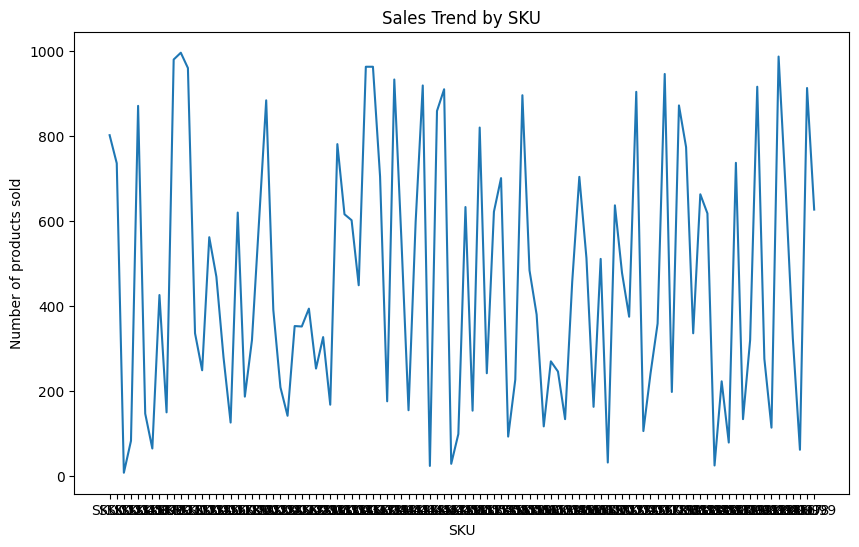

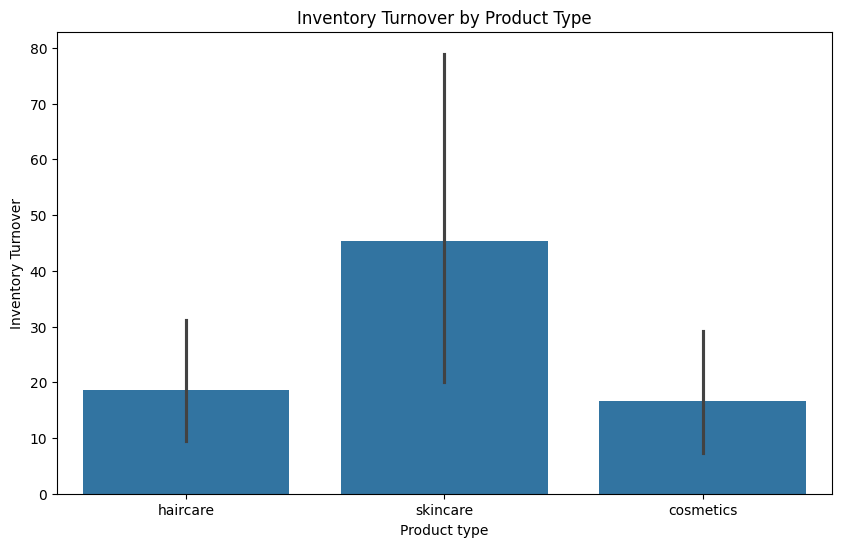

In [5]:
# Descriptive statistics
print(df.describe())

# Sales trend
plt.figure(figsize=(10,6))
sns.lineplot(x='SKU', y='Number of products sold', data=df)
plt.title('Sales Trend by SKU')
plt.show()

# Inventory turnover ratio
df['Inventory Turnover'] = df['Number of products sold'] / df['Stock levels']

plt.figure(figsize=(10,6))
sns.barplot(x='Product type', y='Inventory Turnover', data=df)
plt.title('Inventory Turnover by Product Type')
plt.show()


In [6]:
# Forecasting using ARIMA
product_sales = df['Number of products sold']  # Time series data

# ARIMA model for sales prediction
model = ARIMA(product_sales, order=(5,1,0))
model_fit = model.fit()

# Forecast next 10 periods
forecast = model_fit.forecast(steps=10)
print(forecast)


100    442.241947
101    550.445766
102    608.132867
103    455.442897
104    580.397661
105    586.275276
106    519.006491
107    532.950002
108    575.268316
109    535.045049
Name: predicted_mean, dtype: float64


In [7]:
# Checking the shape of each column to ensure they are 1D
print(df['Lead times'].shape)  # Should return something like (n, )
print(df['Number of products sold'].shape)  # Should also return (n, )
print(df['Stock levels'].shape)  # Should return (n, )

# If any of these contain 2D arrays, flatten them
df['Lead times'] = df['Lead times'].apply(lambda x: x.flatten() if isinstance(x, np.ndarray) and x.ndim > 1 else x)
df['Number of products sold'] = df['Number of products sold'].apply(lambda x: x.flatten() if isinstance(x, np.ndarray) and x.ndim > 1 else x)
df['Stock levels'] = df['Stock levels'].apply(lambda x: x.flatten() if isinstance(x, np.ndarray) and x.ndim > 1 else x)

# Now rerun the Reorder point calculation
df['Lead Time Demand'] = df['Lead times'] * df['Number of products sold'] / df['Stock levels']

# Safety stock calculation (assuming a 95% service level, Z = 1.65)
df['Safety Stock'] = 1.65 * np.sqrt(df['Lead times'].std() * df['Number of products sold'].std())

# Reorder point = Lead Time Demand + Safety Stock
df['Reorder Point'] = df['Lead Time Demand'] + df['Safety Stock']

# Output the optimized reorder points
print(df[['Product type', 'SKU', 'Reorder Point']])


(100,)
(100, 1)
(100,)
   Product type    SKU  Reorder Point
0      haircare   SKU0     182.035229
1      skincare   SKU1     501.845899
2      haircare   SKU2     165.242126
3      skincare   SKU3     132.155169
4      skincare   SKU4     607.842126
..          ...    ...            ...
95     haircare  SKU95     712.442126
96    cosmetics  SKU96      94.913768
97     haircare  SKU97     110.850822
98     skincare  SKU98     102.468541
99     haircare  SKU99     176.442126

[100 rows x 3 columns]


In [8]:
# Flatten the 'Number of products sold' column
df['Number of products sold'] = df['Number of products sold'].values.flatten()

# Recalculate the Lead Time Demand and Reorder Point
df['Lead Time Demand'] = df['Lead times'] * df['Number of products sold'] / df['Stock levels']

# Safety stock calculation (assuming a 95% service level, Z = 1.65)
df['Safety Stock'] = 1.65 * np.sqrt(df['Lead times'].std() * df['Number of products sold'].std())

# Reorder point = Lead Time Demand + Safety Stock
df['Reorder Point'] = df['Lead Time Demand'] + df['Safety Stock']

# Output the optimized reorder points
print(df[['Product type', 'SKU', 'Reorder Point']])


   Product type    SKU  Reorder Point
0      haircare   SKU0     182.035229
1      skincare   SKU1     501.845899
2      haircare   SKU2     165.242126
3      skincare   SKU3     132.155169
4      skincare   SKU4     607.842126
..          ...    ...            ...
95     haircare  SKU95     712.442126
96    cosmetics  SKU96      94.913768
97     haircare  SKU97     110.850822
98     skincare  SKU98     102.468541
99     haircare  SKU99     176.442126

[100 rows x 3 columns]


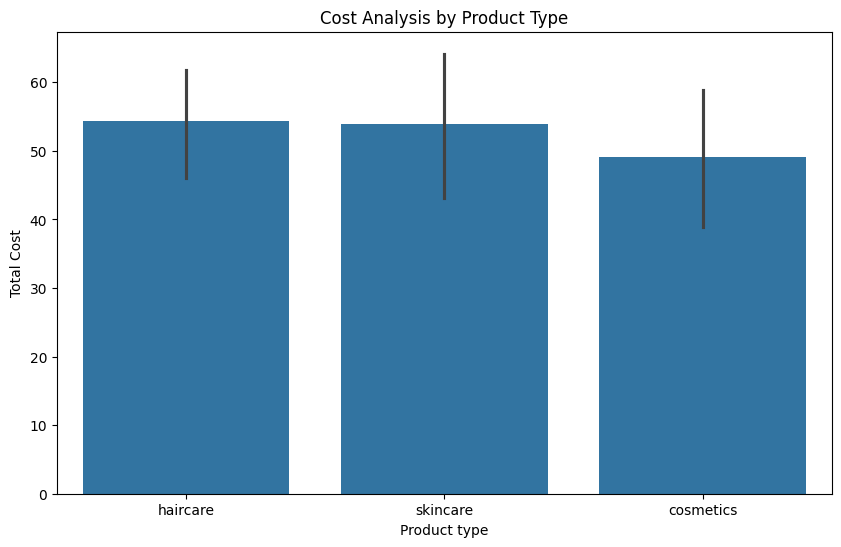

In [9]:
# Total cost = Manufacturing cost + Shipping cost
df['Total Cost'] = df['Manufacturing costs'] + df['Shipping costs']

# Analyze cost per product type
plt.figure(figsize=(10,6))
sns.barplot(x='Product type', y='Total Cost', data=df)
plt.title('Cost Analysis by Product Type')
plt.show()


In [10]:
import simpy

# Simulate supply chain lead times and inventory changes
def supply_chain_simulation(env, stock_level, reorder_point, lead_time):
    while True:
        print(f'Day {env.now}: Stock level: {stock_level}')
        if stock_level <= reorder_point:
            print(f'Day {env.now}: Reordering stock...')
            yield env.timeout(lead_time)  # Wait for lead time to receive stock
            stock_level += 100  # Simulating stock arrival
            print(f'Day {env.now}: Stock received. New stock level: {stock_level}')
        yield env.timeout(1)  # Simulate a day passing

# Initialize simulation
env = simpy.Environment()
env.process(supply_chain_simulation(env, stock_level=50, reorder_point=30, lead_time=5))
env.run(until=30)  # Run for 30 days


Day 0: Stock level: 50
Day 1: Stock level: 50
Day 2: Stock level: 50
Day 3: Stock level: 50
Day 4: Stock level: 50
Day 5: Stock level: 50
Day 6: Stock level: 50
Day 7: Stock level: 50
Day 8: Stock level: 50
Day 9: Stock level: 50
Day 10: Stock level: 50
Day 11: Stock level: 50
Day 12: Stock level: 50
Day 13: Stock level: 50
Day 14: Stock level: 50
Day 15: Stock level: 50
Day 16: Stock level: 50
Day 17: Stock level: 50
Day 18: Stock level: 50
Day 19: Stock level: 50
Day 20: Stock level: 50
Day 21: Stock level: 50
Day 22: Stock level: 50
Day 23: Stock level: 50
Day 24: Stock level: 50
Day 25: Stock level: 50
Day 26: Stock level: 50
Day 27: Stock level: 50
Day 28: Stock level: 50
Day 29: Stock level: 50


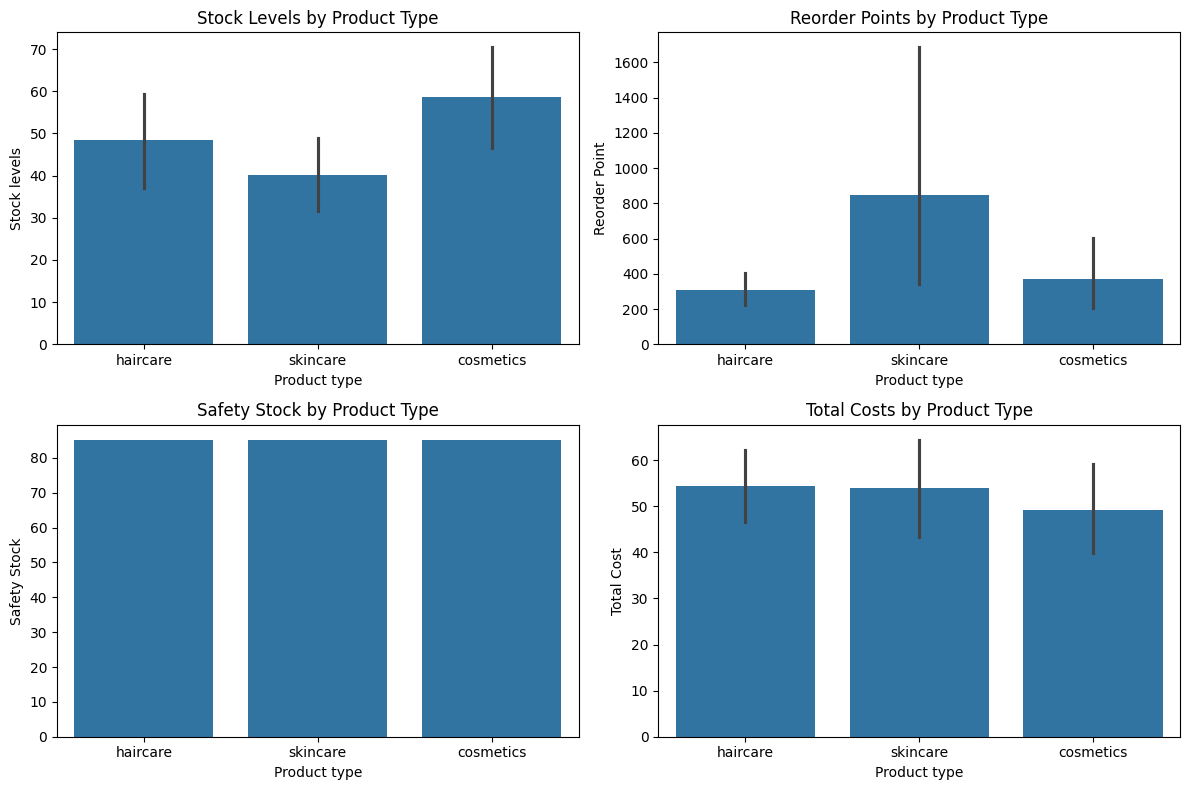

In [11]:
# Inventory Dashboard using matplotlib (Basic version)
plt.figure(figsize=(12,8))

# Plot stock levels
plt.subplot(2,2,1)
sns.barplot(x='Product type', y='Stock levels', data=df)
plt.title('Stock Levels by Product Type')

# Plot reorder points
plt.subplot(2,2,2)
sns.barplot(x='Product type', y='Reorder Point', data=df)
plt.title('Reorder Points by Product Type')

# Plot safety stock
plt.subplot(2,2,3)
sns.barplot(x='Product type', y='Safety Stock', data=df)
plt.title('Safety Stock by Product Type')

# Plot costs
plt.subplot(2,2,4)
sns.barplot(x='Product type', y='Total Cost', data=df)
plt.title('Total Costs by Product Type')

plt.tight_layout()
plt.show()


In [17]:
import numpy as np

# Example calculations for Reorder Point

# Ensure there are no issues with the input columns
print(df[['Lead times', 'Number of products sold', 'Stock levels']].head())

# Calculate Lead Time Demand
df['Lead Time Demand'] = df['Lead times'] * df['Number of products sold'] / df['Stock levels']

# Calculate Safety Stock (assuming a 95% service level, Z = 1.65)
df['Safety Stock'] = 1.65 * np.sqrt(df['Lead times'].std() * df['Number of products sold'].std())

# Calculate Reorder Point
df['Reorder Point'] = df['Lead Time Demand'] + df['Safety Stock']

# Verify new column
print(df[['Lead Time Demand', 'Safety Stock', 'Reorder Point']].head())


   Lead times  Number of products sold  Stock levels
0           7                      802            58
1          30                      736            53
2          10                        8             1
3          13                       83            23
4           3                      871             5
   Lead Time Demand  Safety Stock  Reorder Point
0         96.793103     85.242126     182.035229
1        416.603774     85.242126     501.845899
2         80.000000     85.242126     165.242126
3         46.913043     85.242126     132.155169
4        522.600000     85.242126     607.842126


In [19]:
df[['Product type', 'SKU', 'Reorder Point']].to_csv(r'C:\Users\manik\Desktop\Github\Supply Chain Inventory Optimization\optimized_reorder_points.csv', index=False)
